In [1]:
import bioframe as bf
import pandas as pd
import matplotlib.pyplot as plt

from akita_utils.df_utils import (
    filter_by_chrmlen,
    filter_by_overlap_num,
    filter_by_chromID,
)
from akita_utils.format_io import read_jaspar_to_numpy, read_rmsk

In [2]:
# parameters and paths
ctcf_filter_expand_window = 60
rmsk_filter_expand_window = 20
chrom_sizes_file = "/project/fudenber_735/genomes/mm10/mm10.chrom.sizes.reduced"
autosomes_only = True
seq_length = 1310720

if autosomes_only:
    chromID_to_drop = ["chrX", "chrY", "chrM"]

### Reading boundaries data

In [3]:
# parameters and paths
boundaries_file = "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation"
boundaries = pd.read_csv(boundaries_file, sep="\t")
boundary_strength_thresh = 0.25
boundary_insulation_thresh = 0

window_size = boundaries_file.split("window_")[1].split(".")[0]
boundary_key, insulation_key = (
    f"boundary_strength_{window_size}",
    f"log2_insulation_score_{window_size}",
)

# filtering string boundaries
boundaries = boundaries.iloc[
        (boundaries[boundary_key].values > boundary_strength_thresh)
        * (
            boundaries[insulation_key].values
            < boundary_insulation_thresh
        )
    ]

if autosomes_only:
    boundaries = filter_by_chromID(boundaries, chrID_to_drop=chromID_to_drop)

boundaries = filter_by_chrmlen(
    boundaries,
    chrom_sizes_file,
    seq_length,
)

boundaries.reset_index(drop=True, inplace=True)

In [4]:
print("numer of boundaries: ", len(boundaries))

numer of boundaries:  4474


### Strong CTCFs (top 20%)

In [6]:
strong_CTCFs = pd.read_csv("/home1/smaruj/akitaX1-analyses/input_data/select_top20percent/output/CTCFs_jaspar_filtered_mm10_top20percent.tsv", sep="\t")

In [7]:
len(strong_CTCFs)

300

### Overlapping CTCF df with boundaries df

In [8]:
df_overlap = bf.overlap(
    boundaries, strong_CTCFs, suffixes=("", "_2"), return_index=False, how="inner"
)

In [9]:
# Function to check overlap
def check_overlap(row):
    if row['chrom'] == row['chrom_2']:  # Ensure we are comparing regions on the same chromosome
        return (row['start'] <= row['end_2']) and (row['end'] >= row['start_2'])
    return False

In [10]:
# Add a column to check for overlap
df_overlap['overlap'] = df_overlap.apply(check_overlap, axis=1)

In [11]:
# Group by the (chrom, start, end) region and count how many overlaps there are
overlap_counts = df_overlap.groupby(['chrom', 'start', 'end'])['overlap'].sum().reset_index()

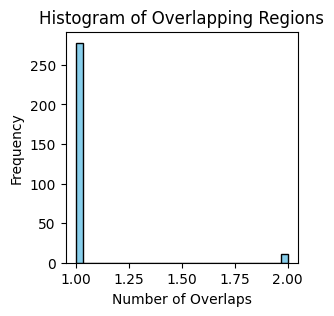

In [12]:
# Plotting the histogram of overlap counts
plt.figure(figsize=(3, 3))
plt.hist(overlap_counts['overlap'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Overlapping Regions')
plt.xlabel('Number of Overlaps')
plt.ylabel('Frequency')
plt.show()

In [13]:
len(df_overlap)

300

In [14]:
len(overlap_counts[overlap_counts['overlap'] == 2])

11

In [15]:
11/300

0.03666666666666667

Number of TAD boundaries with at least one strong CTCF = 289   
Only 11 of them possess 2 strong CTCF sites (3.6%).

### Number of (unfiltered, jaspar) CTCF in the boundary

In [17]:
no_strong_boundary = pd.merge(boundaries, df_overlap[['chrom', 'start', 'end']], 
                          on=['chrom', 'start', 'end'], 
                          how='left', indicator=True)

# Select rows where the indicator shows that there was no match
no_strong_boundary = no_strong_boundary[no_strong_boundary['_merge'] == 'left_only'].drop('_merge', axis=1)

In [24]:
len(no_strong_boundary)

4185

In [18]:
jaspar_file = "/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz"

In [19]:
# read jaspar table (all CTCFs in the mouse genome)
jaspar_df = bf.read_table(jaspar_file, schema="jaspar", skiprows=1)
if autosomes_only:
    jaspar_df = filter_by_chromID(jaspar_df, chrID_to_drop=chromID_to_drop)
jaspar_df.reset_index(drop=True, inplace=True)

In [25]:
len(jaspar_df)

764916

In [20]:
no_strong_df_overlap = bf.overlap(
    no_strong_boundary, jaspar_df, suffixes=("", "_2"), return_index=False, how="inner"
)

In [21]:
no_strong_df_overlap['overlap'] = no_strong_df_overlap.apply(check_overlap, axis=1)

In [22]:
no_strong_overlap_counts = no_strong_df_overlap.groupby(['chrom', 'start', 'end'])['overlap'].sum().reset_index()

In [26]:
len(no_strong_overlap_counts)

3972

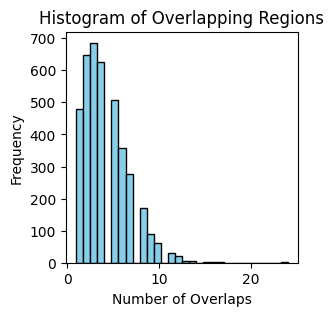

In [23]:
plt.figure(figsize=(3, 3))
plt.hist(no_strong_overlap_counts['overlap'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Overlapping Regions')
plt.xlabel('Number of Overlaps')
plt.ylabel('Frequency')
plt.show()

In [28]:
no_strong_boundary.to_csv("boundaries_no_strong_site.tsv", sep="\t")